In [20]:
## Table & Visualization Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import pickle
import json

## Prediction Libraries
from sklearn.metrics import classification_report, confusion_matrix, \
accuracy_score, plot_confusion_matrix, auc, roc_curve

## Cross-Validation Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

## Model Libraries
from sklearn.tree import DecisionTreeClassifier

In [21]:
## Change this to your new training data
df = pd.read_csv("df_cleaned.csv")
df = df.drop_duplicates(subset='website')

In [22]:
df.head()

,Unnamed: 0,merchant_name,broken_link_score,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist,contact_us_score,tnc_score,links_response,website,fraud_score,label
0,0,CV.ASIATRIPINDONESIA,0.000000,1.0,1.0,1.0,0.0,1.0,1.0,100.0,100.0,{'https://asiatrip.id/reseller/': '<Response [...,http://asiatrip.id/,0.000000,APPROVED
1,1,Pt.BloomingLotusYoga,70.000000,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,{'http://www.blooming-lotus-yoga.com/bliss-mag...,https://www.blooming-lotus-yoga.com,0.000000,APPROVED
2,2,YayasanGreenSejahtera,11.111111,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,"{'': 'No Response/Timeout', 'https://greenseja...",https://greensejahterafoundation.com/,0.000000,APPROVED
3,3,PTMatairTerraSolusi,12.500000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"{'': 'No Response/Timeout', 'https://www.matai...",http://www.matair.co.id,0.666667,APPROVED
4,4,SimplyMii,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,100.0,0.0,{'https://www.simplymii.com/products/category/...,https://www.simplymii.com/,0.000000,APPROVED


In [23]:
y = df['label'].apply(lambda x: 1 if x == 'REJECTED' else 0)

In [24]:
X = df.iloc[:, 2:9]

In [25]:
## Binarize broken_link_score, with threshold 50.0
X["broken_link_score"] = (X["broken_link_score"] < 50.0)

In [26]:
for col in X:
    X[col] = X[col].astype(int)

In [27]:
X.head()

,broken_link_score,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist
0,1,1,1,1,0,1,1
1,0,1,1,1,1,1,1
2,1,1,1,1,1,1,1
3,1,0,0,0,1,0,0
4,1,1,1,1,0,0,0


In [28]:
X.shape

(292, 7)

In [29]:
df.groupby("label").size()

label
APPROVED    215
REJECTED     77
dtype: int64

In [30]:
X.columns

Index(['broken_link_score', 'link_contact_us_exist', 'cu_email_exist',
       'cu_phone_number_exist', 'link_about_us_exist', 'link_tnc_exist',
       'tnc_refund_policy_exist'],
      dtype='object')

## Cross Validation & Hyperparameter Tuning
Adopted from: https://weina.me/nested-cross-validation/

#### Data Splitting

In [31]:
## Divide data into train and "unseen" test set
## Unseen test set will be used for final testing after best hyperparameter sets chose
X_train, X_test_unseen, y_train, y_test_unseen = train_test_split(X, y, test_size=0.25, random_state=42)

In [32]:
y_train.value_counts()

0    159
1     60
Name: label, dtype: int64

In [33]:
y_test_unseen.value_counts()

0    56
1    17
Name: label, dtype: int64

#### Find The Best Hyperparameter Candidates

In [40]:
## Define a parameters grid
p_grid = {"max_depth": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],\
          "min_samples_split": [2,5,10,15,20,25,30],\
          "min_samples_leaf": [1,3,5,10,15]}

In [41]:
## Split train data to 5 (outer) folds
skfold = StratifiedKFold(n_splits=5)

In [42]:
i = 1
folds = []
for train_index_outer, test_index_outer in skfold.split(X_train, y_train):
    fold_data = {}
    
    print("Outer Fold %s" % i)
    data_X_train = X_train.iloc[train_index_outer]
    data_y_train = y_train.iloc[train_index_outer]
    data_X_test = X_train.iloc[test_index_outer]
    
    ## Define model
    model = DecisionTreeClassifier(random_state=0)
    
    ## Do cross validation in inner fold, get the best params
    clf = GridSearchCV(model, p_grid, scoring='roc_auc', cv=skfold)
    clf.fit(data_X_train, data_y_train)
    print("Best Params: %s" % clf.best_params_)
    print("Best Avg. Score: %s" % clf.best_score_)
    fold_data['outer_fold'] = i
    fold_data['best_param'] = clf.best_params_
    fold_data['best_score'] = clf.best_score_
    folds.append(fold_data)
    
    i+=1

Outer Fold 1
Best Params: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 25}
Best Avg. Score: 0.9070427350427351
Outer Fold 2
Best Params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 25}
Best Avg. Score: 0.941565811965812
Outer Fold 3
Best Params: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 25}
Best Avg. Score: 0.9226700854700856
Outer Fold 4
Best Params: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Avg. Score: 0.8841675213675213
Outer Fold 5
Best Params: {'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best Avg. Score: 0.8765811965811967


In [43]:
folds

[{'outer_fold': 1,
  'best_param': {'max_depth': 4,
   'min_samples_leaf': 1,
   'min_samples_split': 25},
  'best_score': 0.9070427350427351},
 {'outer_fold': 2,
  'best_param': {'max_depth': 5,
   'min_samples_leaf': 1,
   'min_samples_split': 25},
  'best_score': 0.941565811965812},
 {'outer_fold': 3,
  'best_param': {'max_depth': 4,
   'min_samples_leaf': 1,
   'min_samples_split': 25},
  'best_score': 0.9226700854700856},
 {'outer_fold': 4,
  'best_param': {'max_depth': 4,
   'min_samples_leaf': 1,
   'min_samples_split': 2},
  'best_score': 0.8841675213675213},
 {'outer_fold': 5,
  'best_param': {'max_depth': 3,
   'min_samples_leaf': 10,
   'min_samples_split': 2},
  'best_score': 0.8765811965811967}]

In [44]:
df_outer_fold_result = pd.DataFrame({"outer_fold":[], "max_depth":[], "min_samples_split":[], "best_score":[]})
for fold in folds:
    res = pd.concat([pd.DataFrame(fold['best_param'], index=[0]),\
                    pd.DataFrame(fold, index=[0]).drop('best_param', axis=1)], axis=1)
    df_outer_fold_result = pd.concat([df_outer_fold_result, res])

In [45]:
df_outer_fold_result

,outer_fold,max_depth,min_samples_split,best_score,min_samples_leaf
0,1.0,4.0,25.0,0.907043,1.0
0,2.0,5.0,25.0,0.941566,1.0
0,3.0,4.0,25.0,0.922670,1.0
0,4.0,4.0,2.0,0.884168,1.0
0,5.0,3.0,2.0,0.876581,10.0


#### Test All Candidates To Unseen Data

In [46]:
pred_class = []
pred_proba = []
pred_auc = []
for fold in folds:
    model = DecisionTreeClassifier(random_state=0,\
                          min_samples_split=fold['best_param']['min_samples_split'],\
                          max_depth=fold['best_param']['max_depth'])
    
    ## Predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_unseen)
    y_pred_proba = model.predict_proba(X_test_unseen)
    
    ## Print metrics
    print("==============================")
    print("Fold %s" % fold['outer_fold'])
    print("Parameter: %s" % fold['best_param'])
    fpr, tpr, thresholds = roc_curve(y_test_unseen, y_pred_proba[:,1])
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_test_unseen, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test_unseen, y_pred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    print("AUC: %.3f" % auc_score)
    print("Accuracy: %.3f " % accuracy)
    print("Precision: %.3f " % precision)
    print("Recall: %.3f " % recall)
    print("F1 Score: %.3f " % f1_score)
    print("True Positive: %s" % tp)
    print("False Positive: %s" % fp)
    print("True Negative: %s" % tn)
    print("False Negative: %s" % fn)
    print("==============================")
    
    pred_class.append(y_pred)
    pred_proba.append(y_pred_proba)
    pred_auc.append(auc_score)

Fold 1
Parameter: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 25}
AUC: 0.908
Accuracy: 0.918 
Precision: 0.867 
Recall: 0.765 
F1 Score: 0.812 
True Positive: 13
False Positive: 2
True Negative: 54
False Negative: 4
Fold 2
Parameter: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 25}
AUC: 0.908
Accuracy: 0.918 
Precision: 0.867 
Recall: 0.765 
F1 Score: 0.812 
True Positive: 13
False Positive: 2
True Negative: 54
False Negative: 4
Fold 3
Parameter: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 25}
AUC: 0.908
Accuracy: 0.918 
Precision: 0.867 
Recall: 0.765 
F1 Score: 0.812 
True Positive: 13
False Positive: 2
True Negative: 54
False Negative: 4
Fold 4
Parameter: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
AUC: 0.908
Accuracy: 0.904 
Precision: 0.812 
Recall: 0.765 
F1 Score: 0.788 
True Positive: 13
False Positive: 3
True Negative: 53
False Negative: 4
Fold 5
Parameter: {'max_depth': 3, 'min_samples_leaf': 10, 'min_sampl

In [59]:
## Best hyperparameter test to unseen data
fold_best = folds[np.argmax(pred_auc)]

In [60]:
## Predict with the best params
model = DecisionTreeClassifier(random_state=0,\
                          min_samples_split=fold_best['best_param']['min_samples_split'],\
                          max_depth=fold_best['best_param']['max_depth'])        
model.fit(X_train, y_train)
y_pred = model.predict(X_test_unseen)
y_pred_proba = model.predict_proba(X_test_unseen)

In [61]:
fpr, tpr, thresholds = roc_curve(y_test_unseen, y_pred_proba[:,1])
auc_score = auc(fpr, tpr)
accuracy = accuracy_score(y_test_unseen, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test_unseen, y_pred).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("AUC: %.3f" % auc_score)
print("Accuracy: %.3f " % accuracy)
print("Precision: %.3f " % precision)
print("Recall: %.3f " % recall)
print("F1 Score: %.3f " % f1_score)
print("True Positive: %s" % tp)
print("False Positive: %s" % fp)
print("True Negative: %s" % tn)
print("False Negative: %s" % fn)

AUC: 0.908
Accuracy: 0.904 
Precision: 0.812 
Recall: 0.765 
F1 Score: 0.788 
True Positive: 13
False Positive: 3
True Negative: 53
False Negative: 4


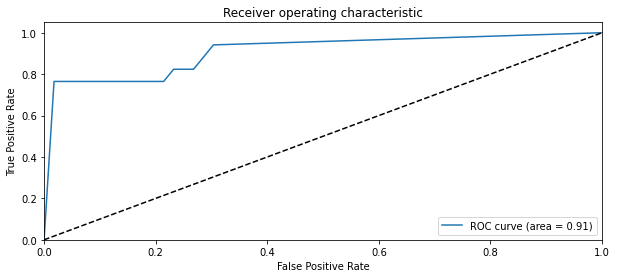

In [62]:
## ROC AUC Graph
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

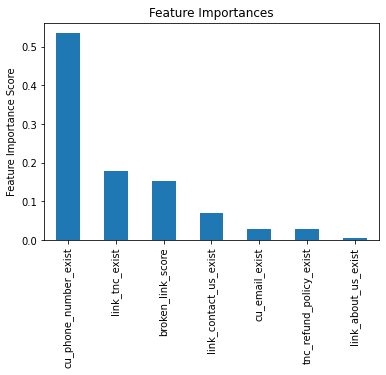

In [63]:
## Calculate feature importance by compute the (normalized) total reduction of the criterion brought by that feature
## Also known as Gini Importance
feat_score = model.tree_.compute_feature_importances()
feat_name = X_train.columns.values

feat_imp = pd.Series(index=feat_name, data=feat_score).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

## Dump To Pickle

In [54]:
# clf = model_choice
# clf = clf.fit(X, y)
# pickle.dump(clf, open('../models/model.pickle', 'wb'))